
Once again, and much like in tutorial 2, we are going to clone the files from our classes **git** repository into the local files for us to access from google colab...



In [5]:
# !git clone https://github.com/NSCC-COGS/GDAA2030.git

Cloning into 'GDAA2030'...
remote: Enumerating objects: 95, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 309 (delta 42), reused 13 (delta 4), pack-reused 214
Receiving objects: 100% (309/309), 15.10 MiB | 36.29 MiB/s, done.
Resolving deltas: 100% (121/121), done.



> An asside: After this is complete it maybe a good idea to comment that out just to avoid accidentally cloning the repo multiple times and making a bit of a mess.. It is really up to you. Everything we do in google colab at this point exists only in the cloud and so you shouldn't worry to much about making a mess. If things get out of hand and your declared variables have become a mess.. or whenever in doubt - start the whole process over (by selecting above.. *Runtime > Restart Runtime... *) You can should then be able to rerun any code blocks without issue. Note that the order that you run the blocks in does matter.. for example if you declare a variable in one and use it in a second - make sure that you do run the first code block before running the second. Lets continue!







Now lets change our working directory to the location of our code and python notebooks from tutorial2. See my example below. This follows the structure of the repo visible on the girhub website. You'll have to switch out my user name for your own to access your code. [if you are having trouble - you may want to consider using my code as a starting point and make a note]. We use the % character to allow for some commands external to python on colab. here we use the '**cd**' command (change directory in linux) to jump to the given folder location. (kind of like we navigte to a folder in windows file explorer but - using linux commands) Doing this will allow us to refernce any files inside the directory without having to write out the entire path each time. 

In [6]:
%cd /content/GDAA2030/tutorial2/kevinkmcguigan

/content/GDAA2030/tutorial2/kevinkmcguigan


Now lets get fancy. Lets run our python notebook(.ipynb) from tutorial 2 again! Here we use a double %% character to access a set of special python notebook / google colab commands - he we use the '**capture**' command which allows us to avoid seeing the output of any python or python notebooks we run while still being able to access any variables after running them. (It would just get a bit busy if we ran our old notebook as saw all the results here) We use the '**run**' command (after a special % character) and specify the name of notebook from tutorial 2 which fetched our landsat scene. This make take some time... (remember we download a landsat scene)

In [0]:
%%capture
%run GDAA2030_T2_kevinmc_getLandsat.ipynb

Just to show that we do indeed have the output and variables from that .ipynb file sitting here as if we had just ran it (because we did..) lets print out the variable from that .ipynb called *selectedScene *...

In [8]:
print(selectedScene)

productId                   LC08_L1TP_009029_20200414_20200414_01_RT
entityId                                       LC80090292020105LGN00
acquisitionDate                           2020-04-14 15:07:22.834829
cloudCover                                                      0.36
processingLevel                                                 L1TP
path                                                               9
row                                                               29
min_lat                                                      43.4713
min_lon                                                      -67.326
max_lat                                                      45.6449
max_lon                                                     -64.2167
download_url       https://s3-us-west-2.amazonaws.com/landsat-pds...
lat                                                          44.5581
lon                                                         -65.7714
dist                              

Remember this is a single entry from a pandas datframe we constructed detailing the landsat scene we downloaded - (which happened to be the 'most recent' scene at a certain location and cloud condition). Now, in tutorial 2 functions script we handled importing pandas, numpy, tiffile and etc for processing everything but we didnt actually import them in the .ipynb file we ran. So lets import some libraries now. (If ever your not sure what you have access to at a given point - it maynot be a bad idea to reimport what you need)

In [0]:
from matplotlib import pyplot as plt
import tifffile
import numpy as np

Great - now. In this tutorial were going to be doing some things with null data values that kind of irritate the numpy library. Just to avoid clutter -  we can turn off the printing of any 'warning' messages in general....

In [0]:
import warnings
warnings.filterwarnings('ignore')

Great! Ok, so. What were going to be doing is some basic image manipulations here. So lets put together a little function to build on what we learned from tutorial 1 - and to give us a little more information about our image than the typical matplotlib imshow() command...

In [0]:
def ourPlot(a, interpolation = 'bilinear', histogram=True):
  stats = {
      'max' : np.nanmax(a),
      'min' : np.nanmin(a),
      'mean' : np.nanmean(a),
      'std' : np.nanstd(a),
      'bitDepth' : a.dtype,
      'dimensions' : a.shape,
      'top_left_value' : a[0,0]
  }

  for item in stats:
    print('%s: %s'%(item, stats[item]))

  plt.cla()
  plt.subplot(121)
  plt.imshow(a ,interpolation = interpolation)
  if histogram:
    plt.subplot(122)
    plt.hist(a.flatten(),bins=100)
    s0 = stats['mean'] - stats['std']
    s1 = stats['mean'] + stats['std']
    plt.axvline(s0,c='red')
    plt.axvline(s1,c='red')

So we can feed this function an numpy array (aka an image) and a series of statistics and information will be printed and the image will be displayed along with a histogram of values including makers for +/- 1 standard deviation. 

Note that we *could* use built in numpy functions to computer statistics for our array **a**, like:

```
a.max(), a.min(), a.mean(), a.std()
```
These would generally give us the maximum value, minimum value, average (or mean), and standard deviation of the the array rather cleanly and efficiently - *UNLESS* - our array contains special 'not a number' or nan values. In which casue to avoid this altogether - we opt to use these special functions instead:

```
np.nanmax(a), np.nanmin(a), np.nanmean(a), np.nanstd(a)
```

They work whether 'nan' values exist or not. (more on that later)


Continuing on - lets use the tifffile library to open the landsat scene as a 2-D numpy array. Remember we downloaded the scene to the local google colab directories when we re-ran our tutorial 2 .ipynb above. (Neat!) ...

max: 65535
min: 0
mean: 6242.864215326385
std: 4622.9840115936195
bitDepth: uint16
dimensions: (8071, 7961)
top_left_value: 0


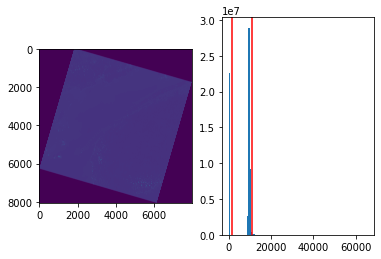

In [17]:
imageFullSize = tifffile.imread(imagePath)
ourPlot(imageFullSize)

So we can see above that our donloaded landsat scene has a max/min which fall within the range of positive integers available in 16 bits of information (thats from Zero to 65,535). We see as well that the type is uint16 (meaning unsigned 16 bit, aka no negative numbers). We can also see that the array is actually quite large ( about 8k by 8k pixels). Also note that the upper left pixel is actually the value 0. This isnt very nice as we would like our statistics (and other processess) to avoid being biased by the 'no data' areas around the scene. 

Lets deal with the size first. Certainly the easiest thing to do in numpy to reduce an 2-d image down to a smaller size is t sample only every n number of values in the rows and columns of the array. If we wanted to, say, take only every 10th pixel in x and y, we could do the following... 

max: 26754
min: 0
mean: 6228.838402362821
std: 4627.317666657472
bitDepth: uint16
dimensions: (808, 797)
top_left_value: 0


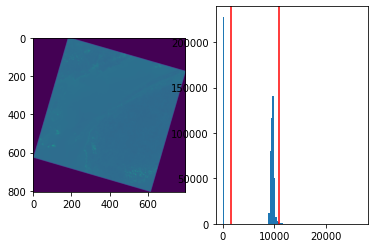

In [52]:
image = imageFullSize[::10,::10]

ourPlot(image)

Ah ha! Now see that our image dimensions are significantly smaller (by a factor of 10) but note that our statistics and max value are also effected. This technique is roughly analogous to a 'nearest neighbor' resampling type and can be good for roughing something together and testing - but generally you want to use a 'better' or more robust form of resampling... Many such libraries exist that may be able to assist you (but we wont go into here) including [rasterio - resample](https://rasterio.readthedocs.io/en/latest/topics/resampling.html) and [skimage - resize](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize) 

A big issue with more sophisticated resampling methods such as bilinear or bicubic is the necessity to *AVOID* including the no data area values into the final result! This is the source of many types of pain in image processing  - specifically for geographic data where no data areas are common. So, Lets address our 'no data area' ... here we can use numpy's magicly simple syntax to build a 'mask' array of the same dimensions but of a boolean type (true or false) based on some logical condition. For example, if your array is 'no data' (ie, not acturally derived from some sensor on the satellite) when the value of the array is zero we can use the following syntax... (note I turn off the histogram in ourPlot function as it does not work for boolean type arrays) 

max: True
min: False
mean: 0.3540815185659093
std: 0.4782340397503811
bitDepth: bool
dimensions: (808, 797)
top_left_value: True


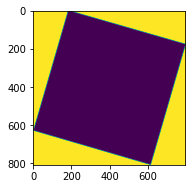

In [59]:
mask = image == 0
ourPlot(mask, histogram=False)

Ah very cool! Now we have a little boolean 'mask array' - but a question remains - what if there are values of zero in the actual data area of the scene? What if some very dark feature returned a value of zero? Now - hopefully the uint16 archive of landsat were accessing is smart enough to avoid such a case - BUT - we can test this ourselves... Theres a really handy command in the scipy.ndimage library called [label](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.label.html).  What this allows us to do is find connected areas of the same pixel value. Four our landsat scene - if there were no values of Zero within the data area then our mask array would have two labels -  one connected area of 'True' and one connected area of 'False' - if there were more than two labels - we know that additional small areas equal to Zero in the origional scene must exist. Lets test it out! ... 

max: 1
min: 0
mean: 0.3540815185659093
std: 0.4782340397503811
bitDepth: int32
dimensions: (808, 797)
top_left_value: 1


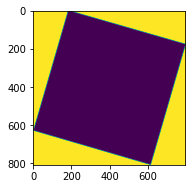

In [60]:
from scipy.ndimage import label
labelMask,unused = label(mask)
ourPlot(labelMask, histogram=False)

Ah ha! It seems (atleast in my landsat scene) that we can show that our simple mask of where the image is equal to one is effective as label only returned two lavel areas, numbered 0 and 1 in this case (see the min and max print out). This output is of type int32 so that you could expect to have many many labels od connected areas with high lavel numbers - nut in this case we only have two. (it is confusing that the label grid *may* look alot like the mask array as a result.. ) ... *Does your label show two labels??*

So! If our mask works... I think we can compute a more meaningful mean average value now for our dataset! Lets use the mask array to do that!

In [62]:
print(image.mean())
print(image[~mask].mean()) # note that litle ~ character works to 'flip' the mask so that true becomes false and vice versa

6228.838402362821
9643.381605265942


Very good! We now have a much more accurate 'mean' value for our selected scene. Lets use this value to generate a new mask that will slice out data basically right down the average 

max: True
min: False
mean: 0.31040908356833175
std: 0.4626610902232865
bitDepth: bool
dimensions: (808, 797)
top_left_value: False


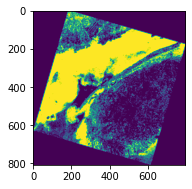

In [63]:
thresholdImage = image > image[~mask].mean() #aka where the image is greater than the mean of the image (not counting the masked area)
ourPlot(thresholdImage, histogram=False)

Now we can start to see why I put in ourPlot function the ability to set a interpolation method... This does not look right at all! The default ['bilinear' interpolation](https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/interpolation_methods.html) of a bool grid will calculate some value between 0 and 1 around the boundaries of 0 and 1 in an 'cool looking' but somewhat misleading way. I should note that this option only effects the visualization of the array performed by matplotlib. Bilinear is really good doe continous data such as photographs but its generally not approroate for thematic arrays or booleans or any type where the values map to some specific non-continous meaning. Its not a rule but this is a good point to understand. But lets just look at what a neatest neighbor interpolation would look like....

max: True
min: False
mean: 0.31040908356833175
std: 0.4626610902232865
bitDepth: bool
dimensions: (808, 797)
top_left_value: False


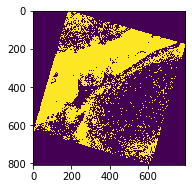

In [64]:
ourPlot(thresholdImage, interpolation = 'nearest', histogram=False)

Ah do you see? Now the plot represents only values of Zeros and Ones. There are no interpolated values inbetween. In some senses this is a much more representative image of the mask. The mask doesn't 'sort of' exist along the edge of Zero and One. It is boolean - all pixels in the image are either masked or not. This effect is much more pronounced now that we are slicing a complex object like our data as opposed to when we were viewing the smooth edges of the no data mask before.

Lets take this oppertunity to have another look at the label function....

max: 13633
min: 0
mean: 766.5822592767432
std: 2219.235715264203
bitDepth: int32
dimensions: (808, 797)
top_left_value: 0


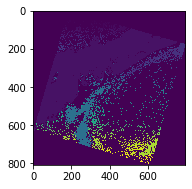

In [65]:
labelThreshold,unused = label(thresholdImage)
ourPlot(labelThreshold, interpolation = 'nearest', histogram=False)

Now - due the complexity of the greater than mean mask  - we see many more labels areas produced. (13634 in my case) We can use another function from numpy called [*unique*](https://docs.scipy.org/doc/numpy/reference/generated/numpy.unique.html) to count the pixels of each label to get their individual total area. Unfortunately the label as such does put a label with a value 'zero' for the areas bellow the mean of our image in this case. Because the input to the unique function is a numpy array, we can use another mask so that values equal to zero are not included. Lets plot the results in terms of their pixel count or 'area'. 

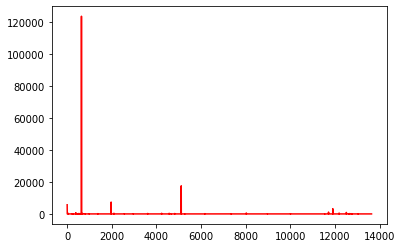

In [69]:
labels, pixelCount = np.unique(labelThreshold[labelThreshold!=0], return_counts=True)
plt.plot(labels, pixelCount, c='red')

Ok so.. when yo see a plot like this the first thing that could jump into mind is.. *I see something but.. its very squished down.. * Calculate the Log!

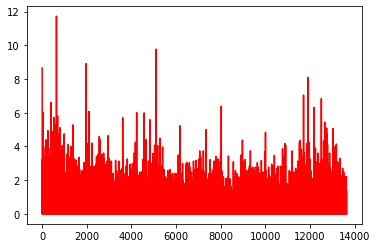

In [70]:
plt.plot(labels, np.log(pixelCount), c='red')


Ah much better - we can see - as we should - an rather complex distribution of sizes of label areas. Note that labels are counted from the top of the image so there really is not much of a relationship in general of number of pixels to label number. Hence the graph (now that we can see it) is rather noisy. 

But lets, say, for example we want to find the largest, or second largest area in this case.. (granted the example is a bit arbitrary - the largest area of pixels greater than the mean pixel value of the scene... but bear with me). Lets run the all powerful numpy [sort function](https://docs.scipy.org/doc/numpy/reference/generated/numpy.sort.html) on our pixel count of each labled area ... 

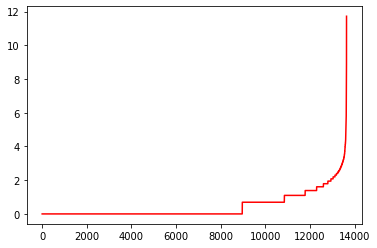

In [71]:
pixelCountorted = np.sort(pixelCount)
plt.plot(np.log(pixelCountorted), c='red')

Well now the sizes are in order but.. what is the label with the maximum area? Introduce probably one of my favourite numpy functions: [argsort](https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html) This is kind of a weird function that allows you to sort an array but instead of returned the array sorted (like np.sort) it actually gives you the 'recipe' in a sense to perform the sort on the array. Now whats really cool about this is that you can argsort say the pixel count array, and use that output, the 'sorter', to sort *another* similar array, like the list of labels - this in turn will sort the labels by the pixel count. We can then grab the value from the end of that array to find the largest label value. We can then use that value as a mask to generate an image of the extent of that largest continous area.... phew.. 

Label: 641
max: True
min: False
mean: 0.19193883001851
std: 0.39382523478014403
bitDepth: bool
dimensions: (808, 797)
top_left_value: False


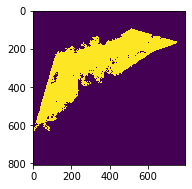

In [72]:
sorter = np.argsort(pixelCount)
largestLabel = labels[sorter][-1] # the -1 will grab the last value in an array, in this case the label with the largest pixel count
print('Label:',largestLabel)

largestArea = (labelThreshold == largestLabel)
ourPlot((largestArea), interpolation='nearest', histogram=False)

lets quicky show the second largest area... 

Label: 5110
max: True
min: False
mean: 0.02727430835931774
std: 0.1628816148705512
bitDepth: bool
dimensions: (808, 797)
top_left_value: False


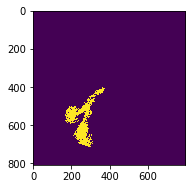

In [74]:
secondLargestLabel = labels[sorter][-2] # this will grab label value with the second largest pixel count
print('Label:', secondLargestLabel)
secondLargestArea = (labelThreshold == secondLargestLabel)
ourPlot((secondLargestArea), interpolation='nearest', histogram=False)

Now again - this a demo of some of the techniques you may use to manipuate image data in a quick and meaningful way. You're use case would be alot more specific than these general examples. I'd like to show you one more veyr useful function in skimage called [dilation](https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.dilation). I've shown you a way to determine, mask, and handle continous areas of certain values in rasters - but in alot of instances you'll find the perimiters of those areas can be quite important as well. Here is a quick way to grab the cells directly surrounding a mask area using the dilation function. What dilation does is simply 'grow' a mask by one pixel. The difference between the mask and the dilated mask is the perimeter. 

max: True
min: False
mean: 0.005431879448923562
std: 0.07350084444804648
bitDepth: bool
dimensions: (808, 797)
top_left_value: False


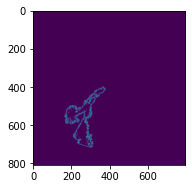

In [76]:
from skimage.morphology import dilation
seconLargestPerm = ~secondLargestArea & dilation(secondLargestArea) # so where it IS NOT the mask area and IS the dilated mask area
ourPlot(seconLargestPerm, interpolation='bilinear', histogram=False) # i did use bilinear to make this just a little easier to see

For example.. the ratio of mask pixels to perimeter pixels can be a very useful metric for classifying regions by their shape... There are many other uses in finding a shapes parimeter - but I'll leave that for you to consider.. 

# Converting to 32 bit
Lets go back now to our downloaded landsat scene and consider that pesky 'no data' region again. Remember in ourPlot function we opted to use the np.nanmax and similar functions to avoid issues with nan values? Well whats a nan value? Its a special desgnation, typically in floating point data types which informs the software or programming language that certain values in an array are not to be considered data. Well why dont you just skip the values? You cant in an array! Kind the defining attribute of an array like a numpy array, without going into too much detail, is that you can jump around and extract a value without looking though the contents of the array (thinkink of grabbing the last value with the index [-1]). Really it comes down to speed! And like alot of things we do for speed - we may have to sacrifice some storage space. Generally the value assigned to a 32but floating point array to be 'not a number' or nan is the lowest possible value (approximately -3.4E+38 - you may see a value like that pop up in your arc map layer file if things are going awry from time to time...)

So lets convert our image to the 32 bit floating point and use the mask we generated earlier to set the no data area to nan....

max: 26754.0
min: 8516.0
mean: 9643.382
std: 471.2296
bitDepth: float32
dimensions: (808, 797)
top_left_value: nan


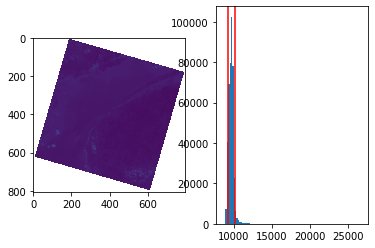

In [77]:
image32 = image.astype(np.float32)
image32[mask] = np.nan
ourPlot(image32)

Ooo fancy white area around the image now! Matplotlib respects the nan values by default and out plots will automatically scale a little nicer based on the actual data range. 

We can use other masks we've generated as well to set no data areas to highlight certain areas of our data... such as the 'largest area' mask we generated.. 

max: 24576.0
min: 9644.0
mean: 9876.311
std: 331.8625
bitDepth: float32
dimensions: (808, 797)
top_left_value: nan


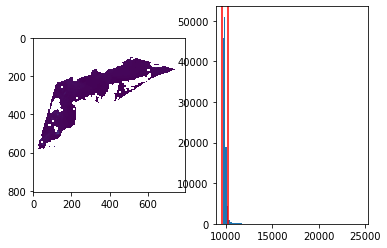

In [80]:
image32LargestArea = image32.copy()
image32LargestArea[~largestArea] = np.nan # anything NOT in the largest area is set to 'not a number'
ourPlot(image32LargestArea)

The scaling of the color ramp isnt great though.. there are [things you can do](https://matplotlib.org/3.2.1/tutorials/colors/colormapnorms.html) with matplotlib to scale the plot based on various sensible values - which is a great idea... but lets do this.. 

lets make a little function to take an imput array ***a***, and scale it to the mean +/- ***n*** standard deviations, and lets do it do that it can either be ***in place*** (overwriting the array) or generate a new copy ... It would look something like this. 

In [0]:
def stdScale(a, n=1, inplace=False):
  if inplace:
    b=a
  else:
    b=a.copy()
  s0 = np.nanmean(b) - np.nanstd(b)/n
  s1 = np.nanmean(b) + np.nanstd(b)/n
  print('Scale from %f to %f' %(s0,s1))
  b[b<s0] = s1 # where the arrays is LESS than the mean - std, SET it to the mean - std
  b[b>s1] = s1# where the arrays is GREATER than the mean + std, SET it to the mean + std
  return b

Now why would we ever want something like that? Well sometimes its nice to have the actual data 'clamped' to a range based on the distribution of data points. This can smoothen out alot of visual processes such as plotting it to matplotlib - and saving the image out as a smaller bit depth -  like the 8bit which is common to images viewed on windows computeres. Lets check it out...

Scale from 9172.152222 to 10114.611450
max: 10114.611
min: 9173.0
mean: 9674.484
std: 267.12094
bitDepth: float32
dimensions: (808, 797)
top_left_value: nan


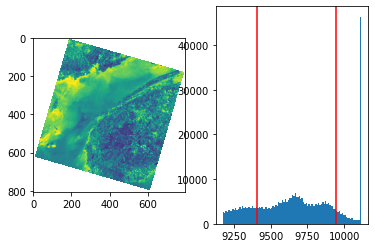

In [85]:
image32_scaled = stdScale(image32)
ourPlot(image32_scaled)

Scale from 9544.448059 to 10208.173035
max: 10208.173
min: 9644.0
mean: 9850.205
std: 135.47702
bitDepth: float32
dimensions: (808, 797)
top_left_value: nan


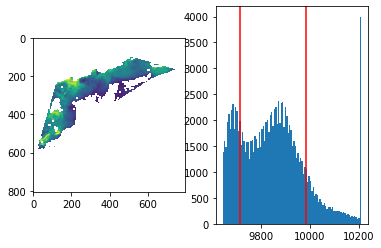

In [83]:
image32LargestArea_scaled = stdScale(image32LargestArea)
ourPlot(image32LargestArea_scaled)

So now we get a lot more detail in both the image plot and the histogram. While we're at it lets throw together a function to convert an array ***a*** to 32 bit, expecting some ***mask value*** to be set to nan, and again - either ***in place*** or not.

In [0]:
def convert32(a, maskVal=0, inplace=False):
  if inplace:
    b=a
  else:
    b=a.copy()
  mask = b == maskVal
  b = b.astype(np.float32)
  b[mask] = np.nan
  return b

Now - I show you this all about moving from 16 bit to 1 bit (masks) to 32 bit for examples because its a bit of a mess out there as to what tools expect what - be it intgers or floating points or RGBA. It turns out to access most of the tools available to you for image analytics - beyond farmiliarizing yourself with pip and github - your next best skill set is probably simply moving between image types. And you should know that if you start in 32 bit and you move to some smaller bit depth like 8 bit - you will likely lose data - so it is important you know how and when to scale data ranges. 


For example... lets take a look at this tool - super useful thing from skimage to find the [local maximum value](https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.peak_local_max) (think like.. the tips of the trees in an elevation model or something) ... as it turns out THIS tool does not seem to work on 32 bit inputs - but does work on 16bit integers.. 

Lets see.... 

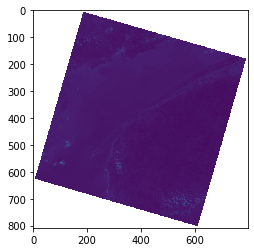

In [98]:
from skimage.feature import peak_local_max

localMaxPts = peak_local_max(image32, min_distance=20) # our image as 32 bit
plt.imshow(image32)
plt.scatter(localMaxPts[:, 1], localMaxPts[:, 0],c='red')

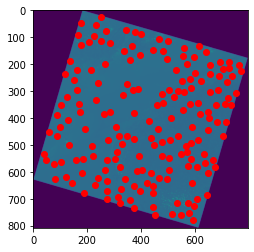

In [96]:
localMaxPts = peak_local_max(image, min_distance=20) # our origninal image in 16bit integer
plt.imshow(image) 
plt.scatter(localMaxPts[:, 1], localMaxPts[:, 0],c='red')

No local max and than many! This is something to be aware of and really highlights the importance of being able to switch between types when trying things out. Some tools conversely only work for floating point rasters. 

One more example ... lets look at the [resize tool](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize) from skimage comparing the results from a 32 bit floating point and 16 bit integer input arrays....

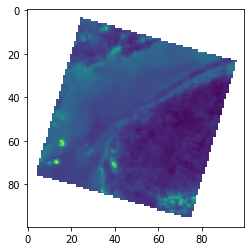

In [109]:
import skimage
image32Resamp = skimage.transform.resize(image32, output_shape = [100,100]) # our image as 32 bit
plt.imshow(image32Resamp)

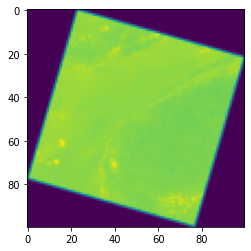

In [110]:
imageResamp = skimage.transform.resize(image, output_shape = [100,100]) # our origninal image in 16bit integer
plt.imshow(imageResamp)

What we see now is that the tool correctly respects the nan of the 32 bit aray while the 16 bit in raster erroneously resamples data into the neighboring Zero values of the no data area. Things to consider!



# Converting to 8 bit

Certainly the most common image type that the average user would come across is 8 bit - or a composite of 3 8 bit rasters (RGB). And as you would expect - a large number of image processing tools are built around 8bit images. Unfortunately for geomatics types - can mean either rewriting tools for 16 or 32 bit, or reducing out data down to 8 bit. Lets look at how we can do that. 

The first thing we'd want to do is normalize the image between 0 and 1 (and actually, even some tools require this format).  As you would expect, to do this requires our data be a floating point type array. So we can build the tool sich that it will convert it up floating point automatically if it isnt. And once again - we can do it ***in place*** on array ***a***, or on a new copy of the array. 

In [0]:
def normalize(a, inplace=False):
  if inplace:
    b=a
  else:
    b=a.copy()

  if b.dtype != np.float32:
    b = b.astype(np.float32)

  b -= np.nanmin(b)
  b /= np.nanmax(b)
  # print(np.nanmin(b), np.nanmax(b))

  return b


We can run this on our 32bit scaled image just to check if the output ranfe is between 0 and 1. 

max: 1.0
min: 0.0
mean: 0.5325816
std: 0.2836849
bitDepth: float32
dimensions: (808, 797)
top_left_value: nan


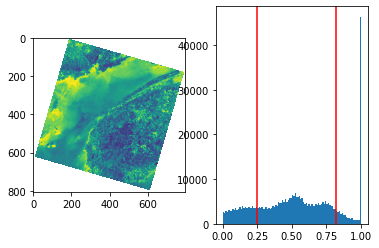

In [114]:
image32_scaled_norm = normalize(image32_scaled)
ourPlot(image32_scaled_norm)

Now, to scale this data (between Zero and 1) into the 8 bit unsigned integer range (Zero to 255) we simply need to multiply the data by 255. But - we may have gone though a fair bit of work up until this point to set the nan on our 32 bit array correctly. And to simply set it to be the value 0 at this point could cause issues down the road. So, we will jump though a couple hoops here to allow an argument where a seperatly ***returned mask array*** can be output based on the nan of the input array - this is done using the numpy [isnan function](https://docs.scipy.org/doc/numpy/reference/generated/numpy.isnan.html). As we've beein doing this will all either happen ***in place*** on the input array or to a new copy. *You may notice I set the mask aray to an 8 bit as well, this is so i can use is as an alpha (aka 'transparency') channel later for creating RGBA composites*

In [0]:
def scale8bit(a, return_mask=True, inplace=False):
  if inplace:
    b=a
  else:
    b=a.copy()

  if return_mask:
    mask = ~np.isnan(b)
  b *= 255
  b = b.astype(np.uint8)

  if return_mask:
    mask = mask.astype(np.uint8)
    mask *= 255

    return b,mask

  else:
    return b


Now lets test the function using the 32 bit version of our image that has been scaled (+/- 1 standard deviation from the mean) and normalised (set between Zero and One). We will create a new mask array as well.

max: 255
min: 0
mean: 87.43310620271563
std: 87.06068763853565
bitDepth: uint8
dimensions: (808, 797)
top_left_value: 0


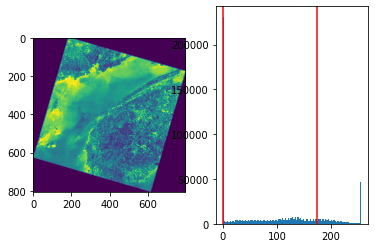

In [116]:
image8Bit,mask8Bit = scale8bit(image32_scaled_norm)
ourPlot(image8Bit)

See the range is now nicely between 0 and 255 adn the values are integers! Note that sadly the value in the top left corner is now Zero and not nan. Thankfully we do have our mask array to carry along with us. (Again, image if there were actual data values equal to zero in the scene!)

Lets plot out mask grid as well and see. 

max: 255
min: 0
mean: 164.70921276569314
std: 121.9496801363471
bitDepth: uint8
dimensions: (808, 797)
top_left_value: 0


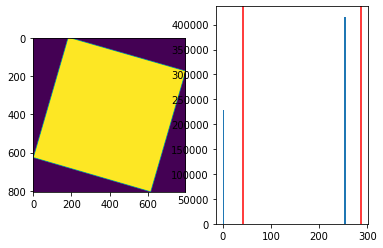

In [117]:
ourPlot(mask8Bit)

# Putting it all together! 

Ok well... if you made it this far.. congratulations! Lets bring a few concepts together and use some of the nifty python tools avilable to us to put a landsat composite onto a webmap! 

So - remember we called ran out tutorial 2 .ipynb file at the begining of this tutorial. So - we actually have access to the functions called in that .ipynb as well! That includes the function which we used to download the scene of a given band. Now that we have a scene selected, we can simply change the band number and run *glf.getImageIO* to download a different band. 

We can design a function now that downloads a list of bands, for example, in the 'true color composite' (4 - Red, 3 - Greem ,and 2 - Blue), appends them to a list of 2-d image arrays, and then 'stack' the list of arrays into a single 3-d numpy array 'composite' image. This is done using our downloading function, the [tifffile](https://scikit-image.org/docs/0.13.x/api/skimage.external.tifffile.html) library, and numpy [dstack function](https://docs.scipy.org/doc/numpy/reference/generated/numpy.dstack.html). 

In [0]:
def makeComposite(bands=[4,3,2]):
  images = []
  for band in bands:
    imageUrl, imagePath = glf.getImageIO(selectedScene, band, imageDir)
    glf.downloadImage(imageUrl,imagePath)
    im = tifffile.imread(imagePath)[::10,::10] # this will reduce the resolution of the images by a factor of 10 
    images.append(im)
    
  return np.dstack(images)

Lets download the data, make a composte and see what it looks like!!

https://s3-us-west-2.amazonaws.com/landsat-pds/c1/L8/009/029/LC08_L1TP_009029_20200414_20200414_01_RT/LC08_L1TP_009029_20200414_20200414_01_RT_B4.TIF .\images/LC08_L1TP_009029_20200414_20200414_01_RT_B4.TIF
downloading... https://s3-us-west-2.amazonaws.com/landsat-pds/c1/L8/009/029/LC08_L1TP_009029_20200414_20200414_01_RT/LC08_L1TP_009029_20200414_20200414_01_RT_B4.TIF
https://s3-us-west-2.amazonaws.com/landsat-pds/c1/L8/009/029/LC08_L1TP_009029_20200414_20200414_01_RT/LC08_L1TP_009029_20200414_20200414_01_RT_B3.TIF .\images/LC08_L1TP_009029_20200414_20200414_01_RT_B3.TIF
downloading... https://s3-us-west-2.amazonaws.com/landsat-pds/c1/L8/009/029/LC08_L1TP_009029_20200414_20200414_01_RT/LC08_L1TP_009029_20200414_20200414_01_RT_B3.TIF
https://s3-us-west-2.amazonaws.com/landsat-pds/c1/L8/009/029/LC08_L1TP_009029_20200414_20200414_01_RT/LC08_L1TP_009029_20200414_20200414_01_RT_B2.TIF .\images/LC08_L1TP_009029_20200414_20200414_01_RT_B2.TIF
downloading... https://s3-us-west-2.amazonaws.com

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


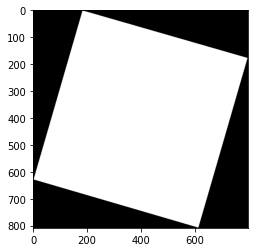

In [119]:
compositeImage = makeComposite([4,3,2])
plt.imshow(compositeImage)

Well.. thats was a tad disapointing.. But it serves a point - this is '16 bit integer data cube' of various bands in the numpy format is really a great thing in terms of the analysis you can perform. But a lot of the visualization tools - like matplotlib arent going to place nicely with it. We can grab data from it across bands using the numpy slice commands, group and cluster things, but.. plt.imshow() makes a white cube. We can fix that using arguments on the inshow function  - but still other visualization tools will fall over on us. 

So, instead - lets make a scaled 8 bit RGBA composite of the same data. 
To do this - we're going to put all out functions together. Using the kinda skeleton format of our *makeComposite* function, lets include our functions to *convert32*, *stdScale*, *normalize*, and *scale8bit*. In the end - were going to be jumping worlds! From the mad scientific GIS world of giant 16 bit rasters of awkward satellite date repositories - to a colorful standard image type that pretty well every visualization tool can read. 

Lets do it!... 

In [0]:
def makeCompositeRGBA(bands=[4,3,2]):
  images = []
  for band in bands:
    imageUrl, imagePath = glf.getImageIO(selectedScene, band, imageDir)
    glf.downloadImage(imageUrl,imagePath)
    im = tifffile.imread(imagePath)[::10,::10] # this will reduce the size of the arrays by a factor of 10x10 to save on memory
    im = convert32(im, inplace=True)
    im = stdScale(im, n=.5, inplace=True) # note that I did play with the number of standard deviation here
    im = normalize(im, inplace=True)
    im,mask = scale8bit(im, return_mask=True, inplace=True)
    images.append(im)
  images.append(mask)

  return np.dstack(images)

So lets run that tool to generate a 'True Color' composite of our landsat scene in glorious 8bit RGBA and use ourPlot to check it out. 

https://s3-us-west-2.amazonaws.com/landsat-pds/c1/L8/009/029/LC08_L1TP_009029_20200414_20200414_01_RT/LC08_L1TP_009029_20200414_20200414_01_RT_B4.TIF .\images/LC08_L1TP_009029_20200414_20200414_01_RT_B4.TIF
.\images/LC08_L1TP_009029_20200414_20200414_01_RT_B4.TIF already found
Scale from 5176.331055 to 9073.518555
https://s3-us-west-2.amazonaws.com/landsat-pds/c1/L8/009/029/LC08_L1TP_009029_20200414_20200414_01_RT/LC08_L1TP_009029_20200414_20200414_01_RT_B3.TIF .\images/LC08_L1TP_009029_20200414_20200414_01_RT_B3.TIF
.\images/LC08_L1TP_009029_20200414_20200414_01_RT_B3.TIF already found
Scale from 6460.693115 to 9143.363525
https://s3-us-west-2.amazonaws.com/landsat-pds/c1/L8/009/029/LC08_L1TP_009029_20200414_20200414_01_RT/LC08_L1TP_009029_20200414_20200414_01_RT_B2.TIF .\images/LC08_L1TP_009029_20200414_20200414_01_RT_B2.TIF
.\images/LC08_L1TP_009029_20200414_20200414_01_RT_B2.TIF already found
Scale from 7679.010254 to 9859.425293
max: 255
min: 0
mean: 97.54565193423358
std: 93.7101

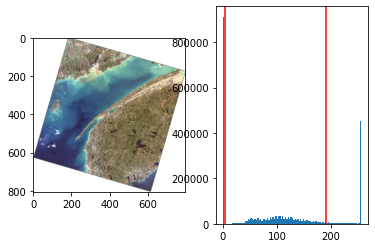

In [125]:
imageRGBA = makeCompositeRGBA([4,3,2])
ourPlot(imageRGBA)

Thats great! Colors we can see! Remember our monitors are generally in 8 bit. And we custom designed our scaling to operate on the range in the data. THis products look really nice but actually are not as robust for analysis. So it is a shame when we convert to this format based on the requirements of a tool - but we do what we have to do! And its good to be flexable with your data types!

Lets take a quick look at thaqt 4th layer in the RGBA (or index 3 in numpy speak) - the 'alpha' channel. Again this is used as a value for 'transparency' - typically where 0 is 'fully transparent' and 255 is 'fully visible'. This is why I returned the mask created in the scale8bit tool with a value of 255. Lets take a look at that portion of the RGBA specifically. (You'll remember this syntax from tutorial 1)

max: 255
min: 0
mean: 164.70921276569314
std: 121.9496801363471
bitDepth: uint8
dimensions: (808, 797)
top_left_value: 0


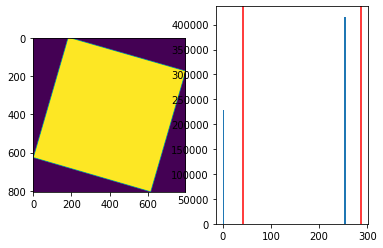

In [126]:
ourPlot(imageRGBA[:,:,3])

I hope that all made some sense!

Now that we have the RGBA version of the landsat composite - lets throw it on a map using [folium](https://python-visualization.github.io/folium/). Folium is a *really* great, lightweight and simple library for making web maps directly from python - and they really appreciate a good numpy array. So much so we can throw our RGBA numpy array right into the [raster_layer.ImageOverlay](https://python-visualization.github.io/folium/modules.html#module-folium.raster_layers) function. It is possible to get the positioning of the data from the tif file itself using tifffile - but we have approximate coordinates the pandas dataframe which we populated from the scene list. 

Check it out below! 

In [127]:
import folium
# folium.Map([45, -63], zoom_start=7, tiles='stamentoner')

m = folium.Map([selectedScene.lat, selectedScene.lon], zoom_start=7)

folium.raster_layers.ImageOverlay(
    image=imageRGBA,
    bounds=[[selectedScene.min_lat, selectedScene.min_lon], 
            [selectedScene.max_lat, selectedScene.max_lon]],).add_to(m)

m